# Frequency correlation plots for natural populations test data with nested clades from a full tree

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] < freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] < freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
min_clade_frequency = 0.15

In [7]:
precision = 4

In [8]:
data_root = "../results/builds/natural/natural_sample_1_with_90_vpm_sliding_test_tree"

In [9]:
data_root_full_tree = "../results/builds/natural/natural_sample_1_with_90_vpm_sliding_full_test_tree"

In [10]:
first_validation_timepoint = "2003-10-01"

In [11]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [12]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [13]:
#tips = np.round(tips, precision)

In [14]:
np.round(tips.head(1), precision)

,strain,timepoint,frequency
0,A/Acre/133946-IEC/2015,2015-04-01,0.0011


In [15]:
(tips["frequency"] > 0).sum()

10101

In [16]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [17]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [18]:
tips_to_clades.head(20)

,strain,clade_membership,depth
0,A/HongKong/33726/2009,4def4f1,0
1,A/HongKong/33726/2009,db0af5e,2
2,A/HongKong/33726/2009,41bb3e2,3
3,A/HongKong/33726/2009,f321e53,5
4,A/Shandong-Zhifu/1203/2009,4def4f1,0
5,A/Shandong-Zhifu/1203/2009,db0af5e,2
6,A/Shandong-Zhifu/1203/2009,41bb3e2,3
7,A/Shandong-Zhifu/1203/2009,f321e53,5
8,A/Gothenburg/3/2009,db0af5e,0
9,A/Gothenburg/3/2009,41bb3e2,3


In [19]:
tips_to_clades.shape

(232803, 3)

In [20]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [21]:
#forecasts = np.round(forecasts, precision)

In [22]:
np.round(forecasts.head(1), 4)

,timepoint,strain,frequency,projected_frequency
0,2015-04-01,A/Acre/133946-IEC/2015,0.0011,0.0002


In [23]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [24]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [25]:
#full_forecasts = np.round(full_forecasts, precision)

In [26]:
full_forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
0,2015-04-01,A/Acre/133946-IEC/2015,0.001147,12.130224,14.651518,-0.570338,0.000229,13.112224,2016-04-01
1,2015-04-01,A/Acre/134221-IEC/2015,0.001917,5.941325,5.578218,0.127309,0.000770,2.539736,2016-04-01
2,2015-04-01,A/Aichi/134/2014,0.000293,7.947723,7.618517,1.458833,0.000445,4.496047,2016-04-01
3,2015-04-01,A/Aichi/96/2015,0.002101,7.058784,7.029317,-1.036411,0.000263,4.380696,2016-04-01
4,2015-04-01,A/Alaska/4032/2014,0.000231,5.059764,4.630501,1.306313,0.000302,1.571674,2016-04-01


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [27]:
tips.head()

,strain,timepoint,frequency
0,A/Acre/133946-IEC/2015,2015-04-01,0.001147
1,A/Acre/134221-IEC/2015,2015-04-01,0.001917
2,A/Aichi/134/2014,2015-04-01,0.000293
3,A/Aichi/96/2015,2015-04-01,0.002101
4,A/Alaska/4032/2014,2015-04-01,0.000231


In [28]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [29]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency
0,A/Guangdong/85/2015,73a6e47,0,2015-04-01,0.001382
1,A/Guangdong/85/2015,a229f16,8,2015-04-01,0.001382
2,A/Guangdong/85/2015,f2ec31a,11,2015-04-01,0.001382
3,A/Guangdong/85/2015,6c1138e,47,2015-04-01,0.001382
4,A/Guangdong/85/2015,38da78c,48,2015-04-01,0.001382


In [30]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [31]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,A/Guangdong/85/2015,73a6e47,0,2015-04-01,0.001382,2016-04-01
1,A/Guangdong/85/2015,a229f16,8,2015-04-01,0.001382,2016-04-01
2,A/Guangdong/85/2015,f2ec31a,11,2015-04-01,0.001382,2016-04-01
3,A/Guangdong/85/2015,6c1138e,47,2015-04-01,0.001382,2016-04-01
4,A/Guangdong/85/2015,38da78c,48,2015-04-01,0.001382,2016-04-01


In [32]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [33]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2015-04-01,2016-04-01,00ab7ec,0.004254
1,2015-04-01,2016-04-01,0165eeb,0.689044
2,2015-04-01,2016-04-01,0324811,0.010056
3,2015-04-01,2016-04-01,03c0e47,0.000036
4,2015-04-01,2016-04-01,03f7c80,0.001141


Merge clade frequencies between adjacent years.

In [34]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [35]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2015-04-01,0165eeb,0.689044,0.830281
1,2015-04-01,0324811,0.010056,0.101195
2,2015-04-01,046d98a,0.001547,0.001336
3,2015-04-01,0dbd131,0.026825,0.145108
4,2015-04-01,1799237,0.018972,0.058953


Select clades with an initial frequency >10%.

In [36]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > %s" % min_clade_frequency).copy()

In [37]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
0,2015-04-01,0165eeb,0.689044,0.830281
6,2015-04-01,1ba36d2,0.164304,0.167717
8,2015-04-01,1edac85,0.164304,0.167717
13,2015-04-01,38da78c,0.999955,0.999982
18,2015-04-01,4717930,0.999955,0.999982


In [38]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
533,2018-10-01,ea08d9e,0.951222,0.854211
536,2018-10-01,f14fabc,0.951222,0.854211
537,2018-10-01,f2ec31a,0.999953,0.999963
538,2018-10-01,f321e53,0.999953,0.999963
539,2018-10-01,f8b8996,0.999953,0.999963


In [39]:
large_clades.shape

(187, 4)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [40]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [41]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,A/Guangdong/85/2015,73a6e47,0,2015-04-01,0.001382,0.000121
1,A/Guangdong/85/2015,a229f16,8,2015-04-01,0.001382,0.000121
2,A/Guangdong/85/2015,f2ec31a,11,2015-04-01,0.001382,0.000121
3,A/Guangdong/85/2015,6c1138e,47,2015-04-01,0.001382,0.000121
4,A/Guangdong/85/2015,38da78c,48,2015-04-01,0.001382,0.000121


In [42]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [43]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,2015-04-01,00ab7ec,0.000662
1,2015-04-01,0165eeb,0.951578
2,2015-04-01,0324811,0.001800
3,2015-04-01,03c0e47,0.000003
4,2015-04-01,03f7c80,0.000079


In [44]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [45]:
complete_clade_frequencies = np.round(complete_clade_frequencies, 2)

In [46]:
complete_clade_frequencies = complete_clade_frequencies.query("frequency != frequency_final").copy()

In [47]:
complete_clade_frequencies.shape

(99, 5)

In [48]:
complete_clade_frequencies["observed_growth_rate"] = (
    complete_clade_frequencies["frequency_final"] / complete_clade_frequencies["frequency"]
)

In [49]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

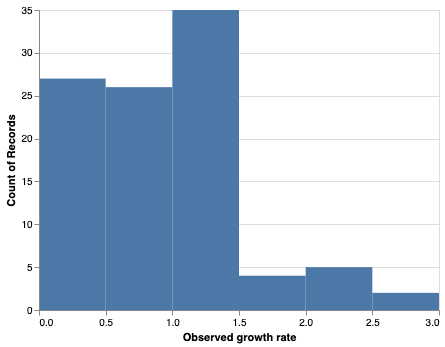

In [50]:
alt.Chart(complete_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

In [51]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [52]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year
0,2015-04-01,0165eeb,0.69,0.83,0.95,1.202899,1.376812,2015
1,2015-04-01,1ba36d2,0.16,0.17,0.02,1.062500,0.125000,2015
2,2015-04-01,1edac85,0.16,0.17,0.02,1.062500,0.125000,2015
5,2015-04-01,66a66dd,0.31,0.17,0.05,0.548387,0.161290,2015
7,2015-04-01,80897ab,0.16,0.17,0.02,1.062500,0.125000,2015


In [53]:
complete_clade_frequencies.shape

(99, 8)

In [54]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [55]:
r

-0.2357726056040369

In [56]:
p

0.01880685712264891

In [57]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [58]:
mcc

0.005024079080430953

In [59]:
confusion_matrix

{'tp': 28, 'tn': 21, 'fp': 32, 'fn': 18}

In [60]:
sum(confusion_matrix.values())

99

In [61]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.4666666666666667

In [62]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.5384615384615384

In [63]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [64]:
pseudofrequency = 0.001

In [65]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

In [66]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate
0,2015-04-01,0165eeb,0.69,0.83,0.95,1.202899,1.376812,2015,0.080123,0.138702
1,2015-04-01,1ba36d2,0.16,0.17,0.02,1.062500,0.125000,2015,0.026170,-0.884607
2,2015-04-01,1edac85,0.16,0.17,0.02,1.062500,0.125000,2015,0.026170,-0.884607
5,2015-04-01,66a66dd,0.31,0.17,0.05,0.548387,0.161290,2015,-0.259764,-0.785190
7,2015-04-01,80897ab,0.16,0.17,0.02,1.062500,0.125000,2015,0.026170,-0.884607


In [67]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

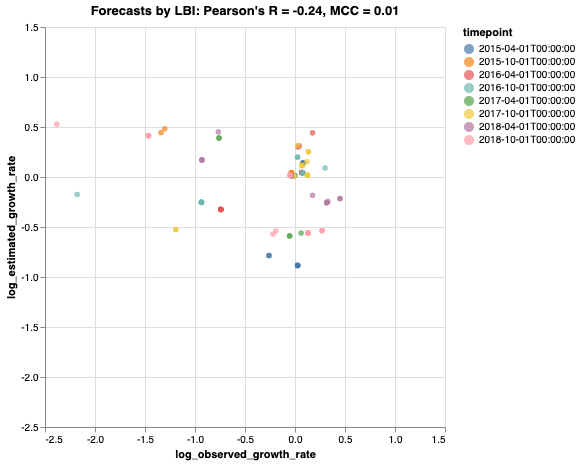

In [68]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [69]:
log_lower_limit

-2.4820170425748684

In [70]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.3820170425748683

In [71]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [72]:
r

-0.19203050050431547

In [73]:
p

0.05688734387481391

In [74]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(-0.2357726056040369, 0.01880685712264891)

In [75]:
complete_clade_frequencies["observed_growth"] = (complete_clade_frequencies["observed_growth_rate"] > 1)

In [76]:
complete_clade_frequencies["estimated_growth"] = (complete_clade_frequencies["estimated_growth_rate"] > 1)

In [77]:
complete_clade_frequencies["accurate_growth"] = (
    (complete_clade_frequencies["observed_growth"]) == (complete_clade_frequencies["estimated_growth"])
)

In [78]:
confusion_matrix

{'tp': 28, 'tn': 21, 'fp': 32, 'fn': 18}

In [79]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
0,2015-04-01,0165eeb,0.69,0.83,0.95,1.202899,1.376812,2015,0.080123,0.138702,True,True,True
1,2015-04-01,1ba36d2,0.16,0.17,0.02,1.062500,0.125000,2015,0.026170,-0.884607,True,False,False
2,2015-04-01,1edac85,0.16,0.17,0.02,1.062500,0.125000,2015,0.026170,-0.884607,True,False,False
5,2015-04-01,66a66dd,0.31,0.17,0.05,0.548387,0.161290,2015,-0.259764,-0.785190,False,False,True
7,2015-04-01,80897ab,0.16,0.17,0.02,1.062500,0.125000,2015,0.026170,-0.884607,True,False,False


In [80]:
(complete_clade_frequencies["estimated_growth_rate"] > 1).sum()

60

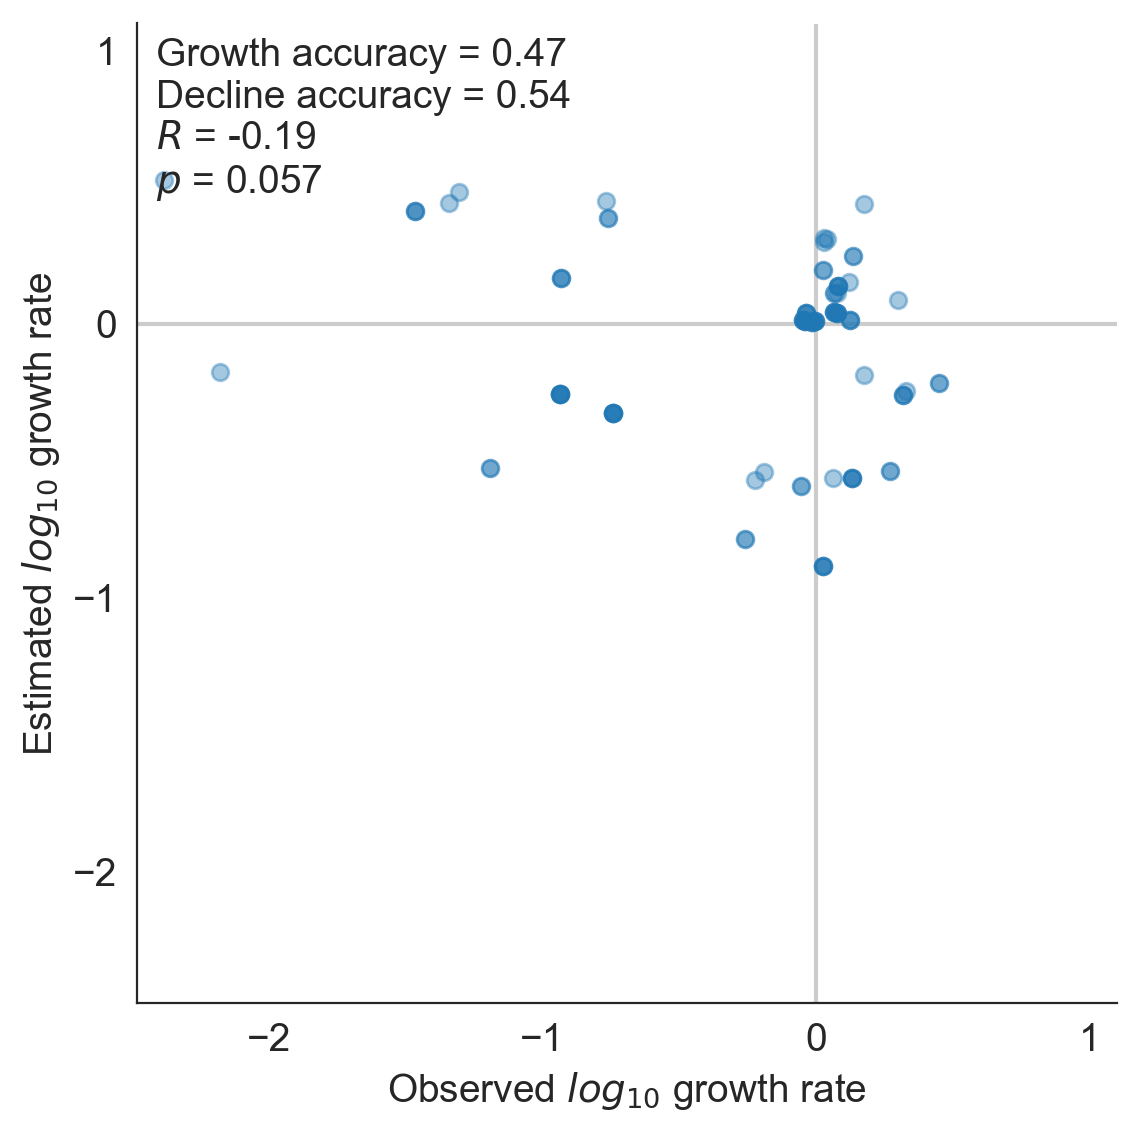

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=14,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("../manuscript/figures/test-of-best-model-for-natural-populations-by-clade-growth.png")

In [82]:
false_positives = (complete_clade_frequencies["log_observed_growth_rate"] < 0) & (complete_clade_frequencies["log_estimated_growth_rate"] > 0)

In [83]:
confusion_matrix

{'tp': 28, 'tn': 21, 'fp': 32, 'fn': 18}

In [84]:
complete_clade_frequencies[false_positives].sort_values("frequency")

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
146,2018-04-01,94d7ef8,0.18,0.03,0.51,0.166667,2.833333,2018,-0.766317,0.450742,False,True,False
22,2015-10-01,0dbd131,0.22,0.01,0.67,0.045455,3.045455,2015,-1.303000,0.482330,False,True,False
32,2015-10-01,e4d8ffe,0.24,0.01,0.67,0.041667,2.791667,2015,-1.340624,0.444705,False,True,False
173,2018-10-01,94d7ef8,0.24,0.00,0.81,0.000000,3.375000,2018,-2.382017,0.527004,False,True,False
161,2018-10-01,020dd15,0.32,0.01,0.83,0.031250,2.593750,2018,-1.465112,0.413096,False,True,False
180,2018-10-01,daeb3db,0.32,0.01,0.83,0.031250,2.593750,2018,-1.465112,0.413096,False,True,False
176,2018-10-01,b60c818,0.32,0.01,0.83,0.031250,2.593750,2018,-1.465112,0.413096,False,True,False
100,2017-04-01,ca3acdb,0.35,0.06,0.86,0.171429,2.457143,2017,-0.759977,0.389696,False,True,False
102,2017-04-01,efde025,0.35,0.06,0.86,0.171429,2.457143,2017,-0.759977,0.389696,False,True,False
149,2018-04-01,b60c818,0.52,0.06,0.77,0.115385,1.480769,2018,-0.931508,0.170217,False,True,False


## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [85]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [86]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [87]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "y"],
    ascending=True
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [88]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2015-04-01,0.063902
1,2015-10-01,0.444924
2,2016-04-01,0.141212
3,2016-10-01,0.098404
4,2017-04-01,0.604814


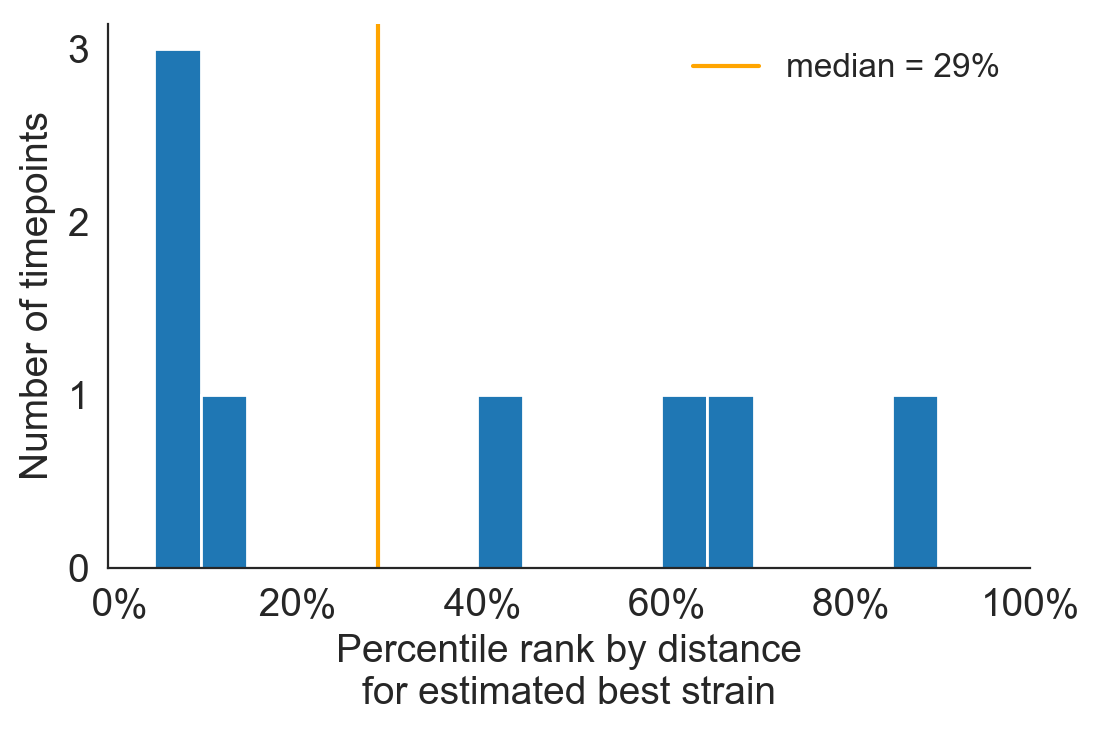

In [89]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
ax.set_ylabel("Number of timepoints")

plt.tight_layout()
plt.savefig("../manuscript/figures/test-of-best-model-for-natural-populations-by-best-strain.png")

## Merge validation figures into subpanels of one figure

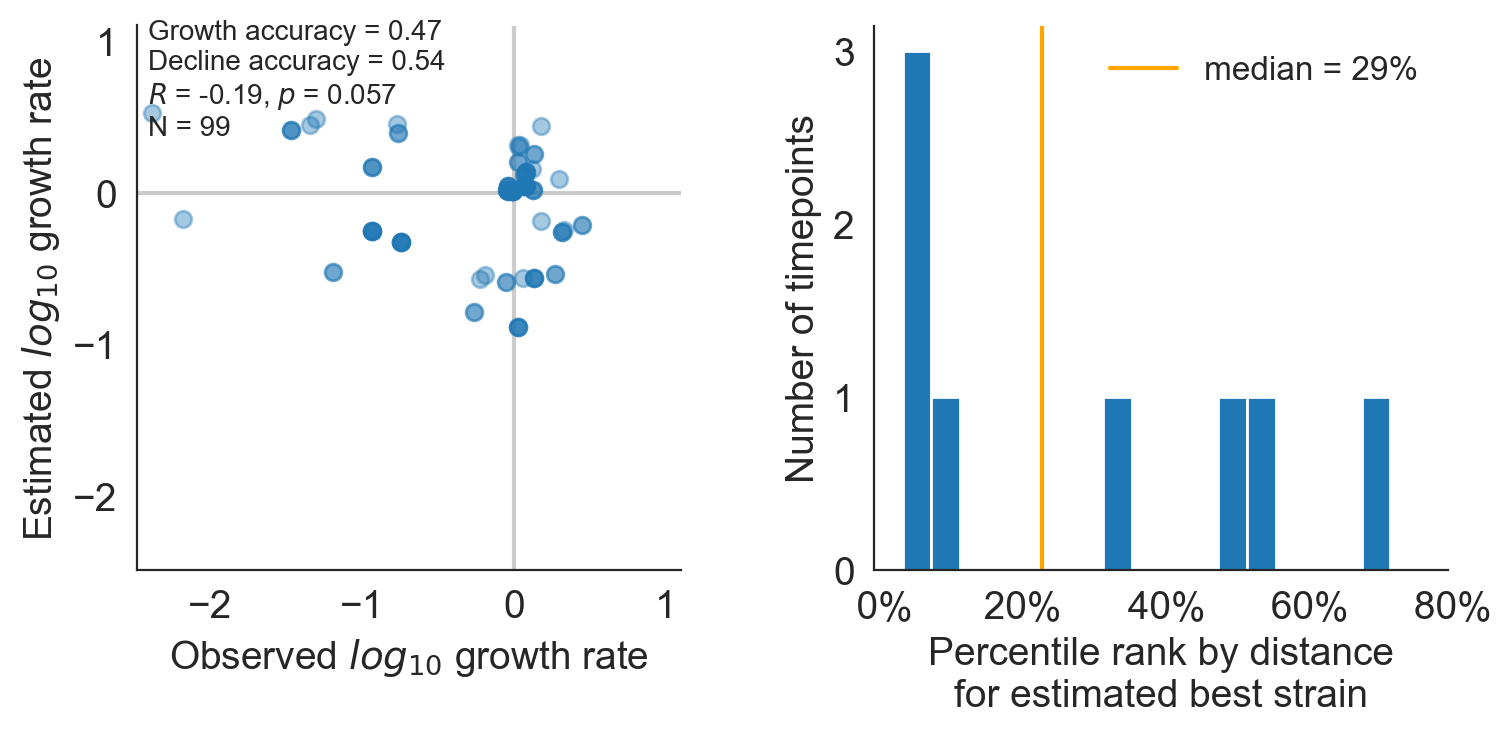

In [90]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f, %s\nN = %s" % (growth_accuracy, decline_accuracy, r, p_value, complete_clade_frequencies.shape[0]),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/test-of-best-model-for-natural-populations.png")

In [91]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] < 0.2).sum()

4

In [92]:
best_fitness_rank_by_timepoint_df.shape

(8, 2)

In [93]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.5

## Inspect uncertainty in forecast accuracy

Use observed forecasting errors to inspect the accuracy of one-year lookaheads based on the initial frequency of each clade.

In [94]:
complete_clade_frequencies.shape

(99, 13)

In [95]:
complete_clade_frequencies["clade_error"] = complete_clade_frequencies["frequency_final"] - complete_clade_frequencies["projected_frequency"]

Text(0,0.5,'Forecast error (%)')

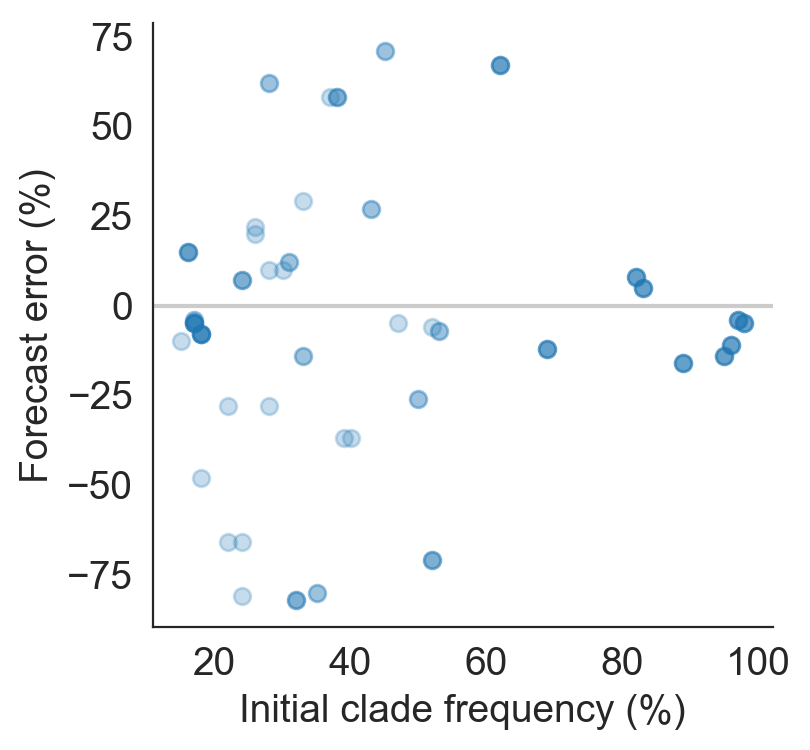

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(
    complete_clade_frequencies["frequency"].values * 100,
    complete_clade_frequencies["clade_error"].values * 100,
    "o",
    alpha=0.25
)
ax.axhline(0, color="#cccccc", zorder=-10)
ax.set_xlabel("Initial clade frequency (%)")
ax.set_ylabel("Forecast error (%)")